# Popular places

#### Visualisation of popular places in Prague

In [11]:
import urllib2
import json
import api_key
import pandas as pd
import colorsys
import time

requestURL = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query=places%20of%20intest%20in%20Prague&key=' + api_key.API_KEY

def parse_next(json_data, names, lats, lngs, ratings):
    parsed = 0
    for result in json_data['results']:
        if (('name' in result) and ('rating' in result) and ('geometry' in result) and ('location' in result['geometry'])
            and ('lat' in result['geometry']['location']) and ('lng' in result['geometry']['location'])):
            names.append(result['name'])
            ratings.append(result['rating'])
            lats.append(result['geometry']['location']['lat'])
            lngs.append(result['geometry']['location']['lng'])
            parsed += 1
    return parsed

names = []
lats = []
lngs = []
ratings = []
parsed = 0
to_parse = 200
next_page_token = None

places = pd.DataFrame()

while parsed < to_parse:
    new_address = requestURL
    if next_page_token is not None:
        new_address = requestURL + '&pagetoken=' + str(next_page_token)

    #print(new_address)
    html = urllib2.urlopen(new_address).read().decode('utf-8')
    data = json.loads(html)
    parsed += parse_next(data, names, lats, lngs, ratings)

    if 'next_page_token' not in data:
        break
    
    next_page_token = data['next_page_token']
    time.sleep(5)
    
places['name'] = names
places['lat'] = lats
places['lng'] = lngs
places['rating'] = ratings
places.to_csv("places.csv", encoding='utf-8')

In [12]:
def rescale_ratings(ratings):
    #print "Max rating: ", max(ratings)
    #print "Min rating: ", min(ratings)
    #print "Avg rating: ", sum(ratings) / len(ratings)
    
    rescaled = [(x - min(ratings)) / (max(ratings) - min(ratings)) for x in ratings]
    return rescaled


In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimg
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import colorsys

MIN_LNG = 14.38
MAX_LNG = 14.45
MIN_LAT = 50.07
MAX_LAT = 50.11

ZOOM_LEVEL = 14
POINT_ALPHA = 1.0
GAUSS_ALPHA = 0.4
SIZE = 70

def make_map(figsize=(16, 12), projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

def show_map(data, colors='green', size=SIZE):
    
    extent = [MIN_LNG, MAX_LNG, MIN_LAT, MAX_LAT]
    
    request = cimg.OSM()
    fig, ax = make_map(figsize=(16,12), projection=request.crs)
    ax.set_extent(extent)

    ax.add_image(request, ZOOM_LEVEL)
    ax.scatter(data['lng'], data['lat'], transform=ccrs.PlateCarree(), alpha=POINT_ALPHA, s=size, c=colors)
    plt.show()

In [14]:
from sklearn import mixture
import numpy as np

def show_gaussian(data, point_colors, components):
    # filtration
    filt = data[data.lng.between(MIN_LNG,MAX_LNG) & data.lat.between(MIN_LAT, MAX_LAT)] 

    X_train = np.array(list(zip(filt['lng'], filt['lat'])))
    clf = mixture.GMM(n_components=components, covariance_type='full', min_covar=0.0000001)
    clf.fit(X_train)

    # show results
    x = np.linspace(MIN_LNG, MAX_LNG)
    y = np.linspace(MIN_LAT, MAX_LAT)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T 
    Z = clf.score_samples(XX)[0]
    Z = Z.reshape(X.shape)

    extent = [MIN_LNG, MAX_LNG, MIN_LAT, MAX_LAT]
    
    request = cimg.OSM() 
    fig, ax = make_map(figsize=(16,12), projection=request.crs)
    ax.set_extent(extent)

    ax.add_image(request, ZOOM_LEVEL)
    ax.scatter(data['lng'], data['lat'], transform=ccrs.PlateCarree(), alpha=POINT_ALPHA, s=SIZE, c=point_colors)
    ax.contourf(X, Y, Z, transform=ccrs.PlateCarree(), levels=np.linspace(np.min(Z), np.max(Z)), alpha=GAUSS_ALPHA)

    plt.show()

In [15]:
import pandas as pd
import colorsys

def show_all_graphs(data_frame):
    places = data_frame

    ratings = places['rating']
    rescaled = rescale_ratings(ratings)

    colors_normal = [0] * len(ratings)
    colors_scaled = [0] * len(ratings)
    for i in range(len(ratings)):
        colors_normal[i] = colorsys.hsv_to_rgb(ratings[i] / 5.0 / 3.6, 1, 1)
        colors_scaled[i] = colorsys.hsv_to_rgb(rescaled[i] / 3.6, 1, 1)
    
    print "Total places: ", len(places)
    
    show_map(places, colors_normal)
    show_map(places, colors_scaled)
    
    N_COMPONENTS = 5
    
    show_gaussian(places, colors_normal, N_COMPONENTS)
    
    places_multi = places.copy()
    colors_multi = list(colors_scaled)
    rr = rescale_ratings(ratings)
    for i in range(len(places)):
        value = rr[i]
        count = 0
        if (0.2 <= value < 0.4):
            count += 0
        if (0.4 <= value < 0.6):
            count += 1
        if (0.6 <= value < 0.8):
            count += 3
        if (0.8 <= value < 1.0):
            count += 4
        
        for j in range(count):
            df = places.loc[i]
            places_multi = places_multi.append(df)
            colors_multi.append(colors_scaled[i]) 
            
    show_gaussian(places_multi, colors_multi, N_COMPONENTS)

Total places:  52


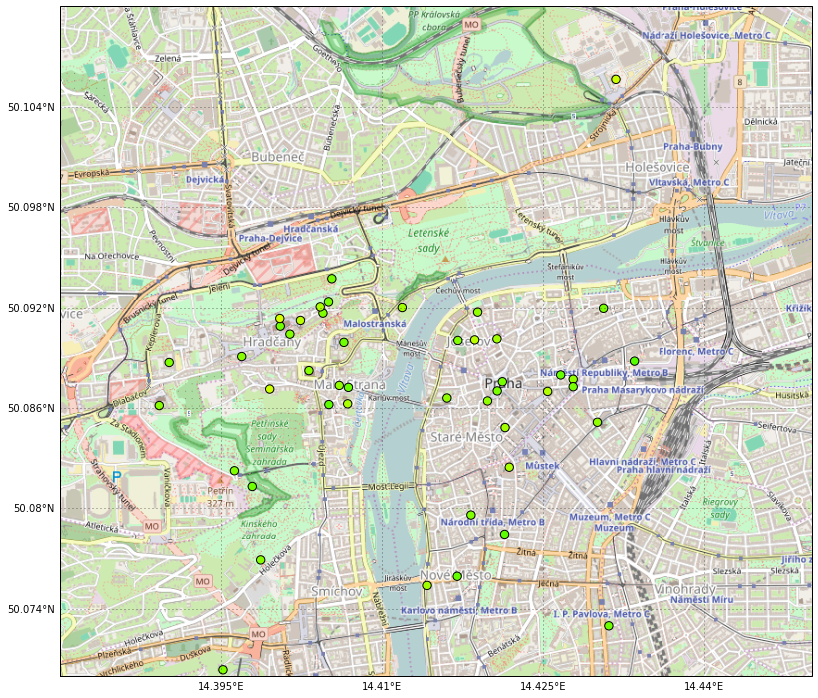

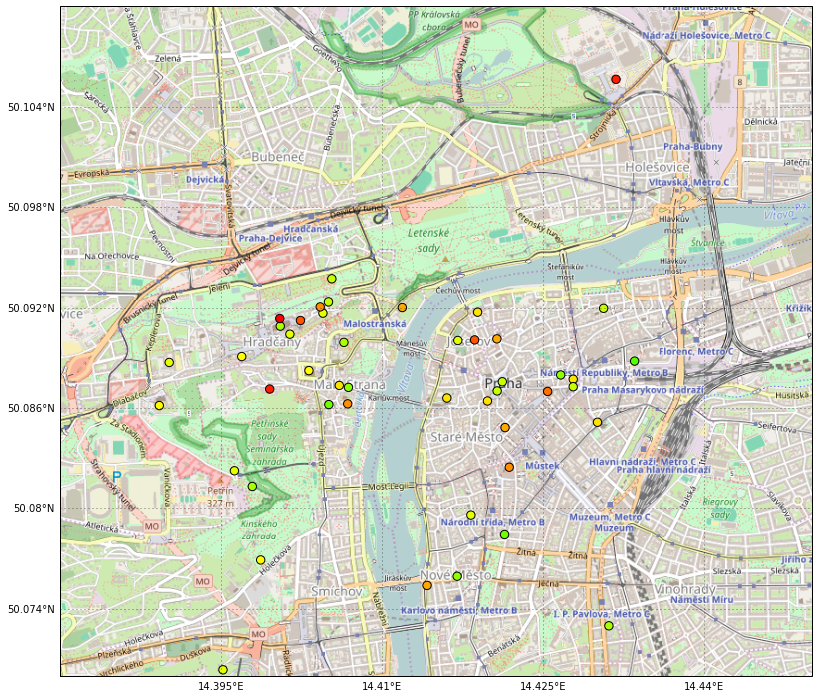

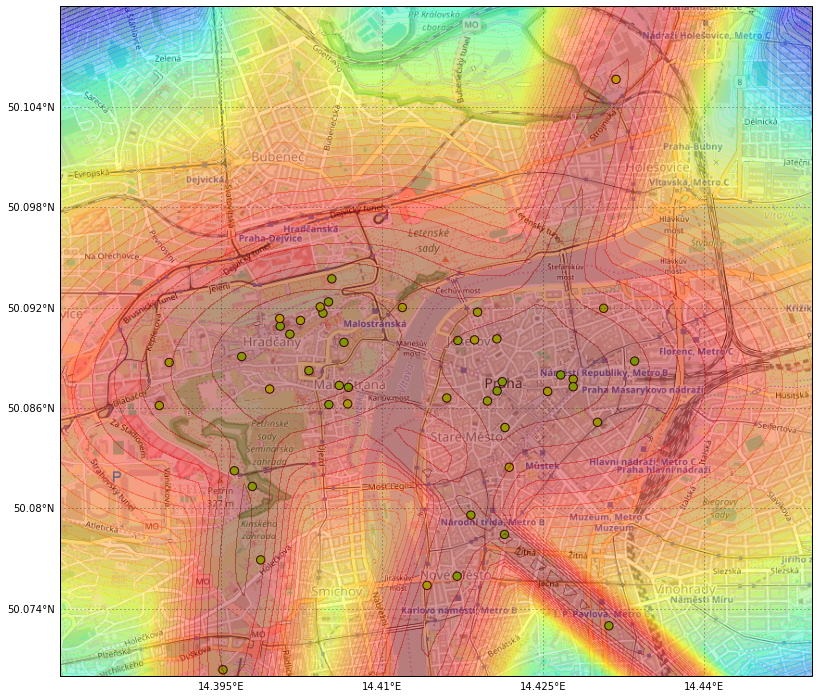

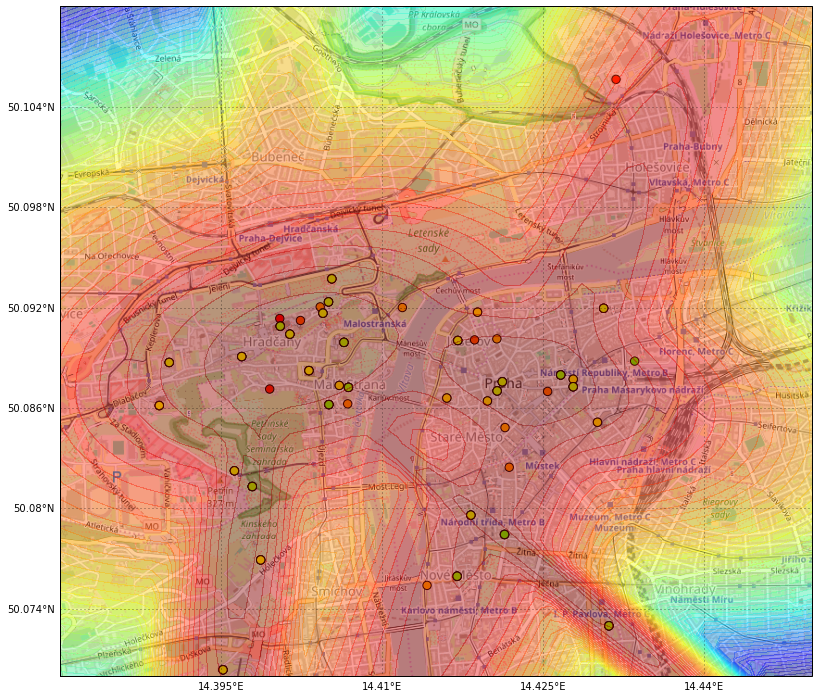

In [5]:
places = pd.DataFrame.from_csv("places.csv")
show_all_graphs(places)

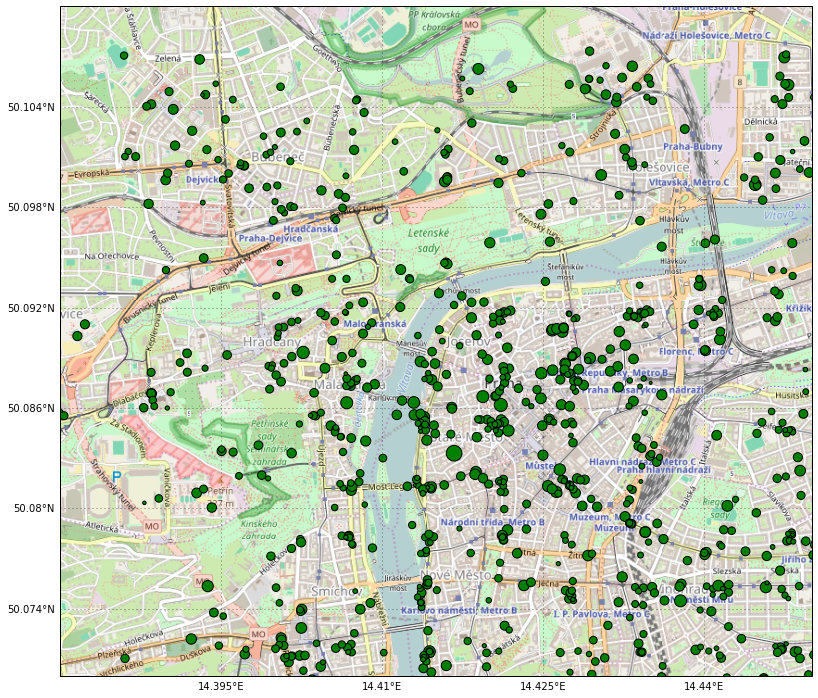

In [17]:
import math

places = pd.DataFrame.from_csv("facebook_dataframe.csv")
places.columns = ['checkins', 'fan_count', 'name', 'lat', 'lng']
sizes = [0] * len(places)
for i in range(len(places)):
    value = places['fan_count'][i] + places['checkins'][i]
    size = 1 # default size
    if (value > 0):
        size = math.log(value)
    sizes[i] = size ** 2
    
show_map(places, size=sizes)